# Housing Price Prediction with Feature Engineering

## 1. Introduction

This project addresses a supervised regression problem using structured housing data from the Kaggle Housing Prices dataset. The goal is to predict house sale prices based on a range of numerical and categorical property features.

Emphasis is placed on feature engineering, model comparison, and validation-based evaluation. Baseline models are assessed and compared using RMSE and R² metrics, with a Random Forest Regressor selected as the final model for generating predictions on unseen test data.

## 2. Project Objectives

- Perform exploratory data analysis to understand key factors influencing house prices
- Clean and preprocess structured housing data
- Apply feature engineering techniques to improve model performance
- Train and evaluate baseline regression models
- Select an appropriate model based on validation performance
- Generate house price predictions on unseen test data

## 3. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Dataset Source

The dataset used in this project is the Kaggle Housing Prices dataset. Due to Kaggle's data usage policy, the dataset files are not included in this repository.

To run this notebook locally:
1. Download the dataset from Kaggle
2. Place `train.csv` and `test.csv` in the project root directory

## 4. Load Dataset

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Display basic information
train_df.head(), train_df.shape

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

In [3]:
# Basic dataset information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 5. Exploratory Data Analysis (EDA)

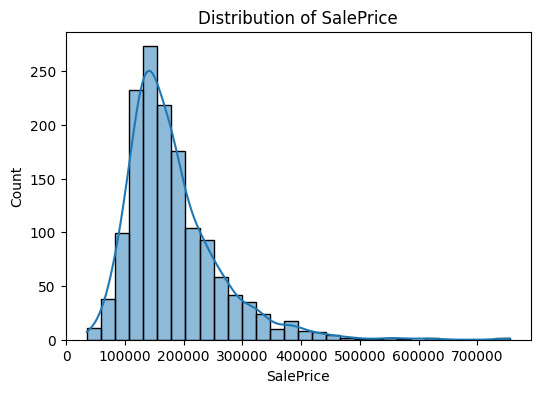

In [4]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.histplot(train_df["SalePrice"], bins=30, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

SalePrice is right-skewed, which clearly shows that lower priced houses are more frequent.

In [5]:
# Missing values count
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values.head(10)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


In [6]:
# Correlation with target variable
corr = train_df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
corr.head(10)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


## 6. Data Cleaning

In [7]:
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]

In [8]:
# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Fill missing values
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

In [9]:
X.isnull().sum().sum()

np.int64(0)

## 7. Feature Engineering

In [10]:
# Create new features

# Age of the house at Sale
X["HouseAge"] = X["YrSold"] - X["YearBuilt"]

# Total bathrooms (full + half weighted)
X["TotalBathrooms"] = (
    X["FullBath"]
    + 0.5 * X["HalfBath"]
    + X["BsmtFullBath"]
    + 0.5 * X["BsmtHalfBath"]
)

In [11]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [12]:
# Log-transform the target variable
y_log = np.log1p(y)


In [13]:
X_encoded.shape

(1460, 247)

## 8. Train-Validation Split

In [14]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded,
    y_log,
    test_size=0.2,
    random_state=42
)

## 9. Model Training

### 9.1 Linear Regression (Baseline)

In [15]:
# Baseline model: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_val)

### 9.2 Random Forest Regression

In [16]:
# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=0,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
rf_preds = rf_model.predict(X_val)

## 10. Model Evaluation

In [17]:
# Reset Evaluation results to avoid duplication
results = []
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return{
        "Model": model_name,
        "RMSE": rmse,
        "R2": r2
    }


In [18]:
lr_results = evaluate_model(y_val, lr_preds, "Linear Regression")
results.append(lr_results)

In [19]:
rf_results = evaluate_model(y_val, rf_preds, "Random Forest Regression")
results.append(rf_results)

Model performance is evaluated on the validation set using RMSE and R².

## 11. Model Comparison

In [20]:
model_comparison = pd.DataFrame(results)
model_comparison.sort_values(by="RMSE")

,Model,RMSE,R2
1,Random Forest Regression,0.149339,0.880489
0,Linear Regression,0.213133,0.756576


## 12. Final Model Selection

Two baseline models were evaluated using validation performance:

- Linear Regression served as a simple baseline model.
- Random Forest Regressor demonstrated significantly improved performance.

Based on lower RMSE and higher R² on the validation set, the Random Forest Regressor was selected as the final model for generating house price predictions.

**Note:** RMSE is computed on the log_transformed target variable (`log1p(SalePrice)`).

## 13. Final House Price Prediction

The trained model is used to generate house price predictions on unseen test data. This simulates a real-world scenario where the model is applied to new listings.

In [21]:
# Encode test dataset using the same features as training data
test_encoded = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Align test features with training features
test_encoded = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

In [22]:
# Predict log-transformed prices
test_preds_log = rf_model.predict(test_encoded)

# Convert predictions back to original scale
test_preds = np.expm1(test_preds_log)

test_preds[:5]

array([122032.60245273, 145031.94454658, 162998.24733987, 164161.73023937,
       200942.08339216])

In [23]:
# Create prediction DataFrame
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_preds
})
submission

,Id,SalePrice
0,1461,122032.602453
1,1462,145031.944547
2,1463,162998.247340
3,1464,164161.730239
4,1465,200942.083392
...,...,...
1454,2915,88235.879511
1455,2916,94970.022873
1456,2917,141974.722063
1457,2918,104372.861829


## 14. Conclusion & Next Steps

This project demonstrated a complete machine learning workflow for predicting house prices using structured data. Emphasis was placed on feature engineering, baseline model evaluation, and validation-based model selection. A Random Forest Regressor achieved the best validation performance and was used to generate final predictions on unseen data.

Future improvements may include hyperparameter tuning, feature selection, and experimenting with advanced ensemble models to further improve predictive performance.